# Field Goals: An Observational Study ⛰️

* Hypothesis: Long range field goals have a greater change of conversion at altitude than sea-level.
* Hypothesis: Icing a kicker prior to an attempty reduces the likelihood of conversion.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from matching.cem import CEM, imbalance
from util.fg_data import clean, get_data

import pandas as pd
import numpy as np
import mysql.connector
import itertools
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_palette('colorblind')
from datetime import datetime as dt

## Preprocessing

In [2]:
# load and clean the data
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df = df.drop(['fkicker', 'home_team', 'stadium', 'team', 'XP', 'humid', 'kicks', 'age', 'form'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18803 entries, 2166 to 871048
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   good           18803 non-null  int64
 1   dist           18803 non-null  int64
 2   year           18803 non-null  int64
 3   seasons        18803 non-null  int64
 4   temperature    18803 non-null  int32
 5   altitude       18803 non-null  int64
 6   wind           18803 non-null  int32
 7   away_game      18803 non-null  int64
 8   postseason     18803 non-null  int64
 9   iced           18803 non-null  int64
 10  turf           18803 non-null  int64
 11  precipitation  18803 non-null  int64
 12  pressure       18803 non-null  int64
dtypes: int32(2), int64(11)
memory usage: 1.9 MB


In [3]:
# df = pd.read_csv('../data/field_goals.csv', index_col=0)
# df.drop(['kicks','age','form'], axis=1, inplace=True)
# df.info()

## Variable of Interest

We filter for away kicks at altitude because only Denver home games are at altitude, so need to avoid biasing for Broncos kicker?

In [4]:
# T = 'iced'
# drop = []

T = 'altitude'
drop = ['turf']
# df[on] = df[on].astype(bool)

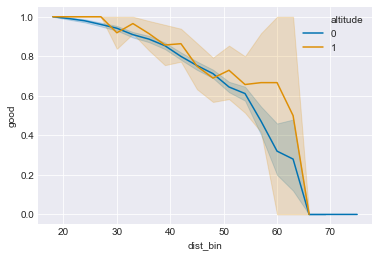

In [5]:
df_ = df.copy()
df_['dist_bin'] = 3*round(df_['dist']/3)
sns.lineplot(x='dist_bin', y='good', hue=T, data=df_)

In [6]:
print(df[T].value_counts())

0    18168
1      635
Name: altitude, dtype: int64


In [7]:
df

,good,dist,year,seasons,temperature,altitude,wind,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,,
2166,1,38,2000,17,22,0,10,1,0,0,1,0,1
2185,1,27,2000,17,22,0,10,1,0,0,1,0,1
4565,1,36,2000,17,26,0,13,0,0,1,0,0,5
8564,1,24,2000,17,16,0,16,1,0,0,1,1,1
8628,1,40,2000,17,16,0,16,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
862982,1,30,2019,3,18,0,0,0,0,0,0,0,1
865338,1,21,2019,3,18,0,11,0,0,0,0,0,2
868268,1,22,2019,3,6,0,7,1,0,0,1,0,1


## One-to-many CEM with weighted linear regression - relaxed on distance
## k-k CEM with linear regression - relaxed on distance
## One-to-many CEM with weighted t-test / z-test (for altitude only on long range kicks?)
## k-k CEM with t-test / z-test (as above)
## One-to-many with Bayesian difference of means (May not be possible with beta-binomial conjugacy) (as above)
## k-k CEM with Bayesian difference of means (as above)

### We setup our cem matcher which will calculate H (including bin edges) for imbalance calculations if it is not provided explicitly.

In [8]:
continuous = ['dist', 'year', 'seasons', 'temperature', 'wind', 'pressure']
cem = CEM(df, T, 'good', continuous, H=5)
# cem = CEM(df, T, 'good', continuous)

### Else we can calculate the imbalance outside of the cem object, for a range of H's, for both the raw data and post-matched data.

Below is a base coarsening schema that we can relax or whatever as we see fit.

In [9]:
coarsening = {
    'dist': {'bins': 4, 'cut': 'cut'}, # relax over
    'year': {'bins': 4, 'cut': 'cut'}, # uniform so qcut=cut
    'seasons': {'bins': [0, 0.25, 0.75, 1], 'cut': 'qcut'}, # quantiles
    'temperature': {'bins': [0, 0.05, 0.5, 0.95, 1], 'cut': 'qcut'}, #quantiles
    'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
    'pressure': {'bins': [-1,1,4,6], 'cut': 'cut'},
    'postseason': {'bins': 2, 'cut': 'cut'},
    'iced': {'bins': 2, 'cut': 'cut'},
    'precipitation': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
    'turf': {'bins': 2, 'cut': 'cut'},
    'away_game': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
}
coarsening.pop(T)
coarsening

{'dist': {'bins': 4, 'cut': 'cut'},
 'year': {'bins': 4, 'cut': 'cut'},
 'seasons': {'bins': [0, 0.25, 0.75, 1], 'cut': 'qcut'},
 'temperature': {'bins': [0, 0.05, 0.5, 0.95, 1], 'cut': 'qcut'},
 'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
 'pressure': {'bins': [-1, 1, 4, 6], 'cut': 'cut'},
 'postseason': {'bins': 2, 'cut': 'cut'},
 'iced': {'bins': 2, 'cut': 'cut'},
 'precipitation': {'bins': 2, 'cut': 'cut'},
 'turf': {'bins': 2, 'cut': 'cut'},
 'away_game': {'bins': 2, 'cut': 'cut'}}

In [ ]:
# Put this in the CEM class somewhere
# rows = []
# cont_bins = range(1,10)
# weights = cem.match(coarsening)
# for H in cont_bins:
#     # we use H bins for continuous variables when evaluating imbalance
#     original_imbalance, (bins, ranges) = imbalance(cem.data.drop('good', axis=1), T, continuous=continuous, H=H, retargs=True)
#     rows.append(pd.Series({'data':'raw', 'measure':original_imbalance, 'H': H}))
#     cem_imbalance = imbalance(cem.data.drop('good', axis=1).loc[weights>0, :], T, bins=bins, ranges=ranges) # same bins and ranges as raw data histogram
#     rows.append(pd.Series({'data':'CEM', 'measure':cem_imbalance, 'H': H}))
# imbalance = pd.DataFrame.from_records(rows)
# ax = sns.lineplot(x='H', y='measure', hue='data', data=imbalance, markers=True, style='data')
# ax.set_title('L1 score for different continuous binnings')

## L1 for depth>=1 and one-to-many

We can relax the coursening progressively on any number of covariates.

In [19]:
relax_on = [('dist', range(2,4), 'cut'), ('seasons', range(3,5), 'cut')]
relaxed = cem.relax(coarsening, relax_on)

100%|██████████| 4/4 [00:33<00:00,  8.27s/it]


In [20]:
relaxed.coarsenings

imbalance measure  \
var             n_bins                      
(dist, seasons) (2, 3)   0.643102      l1   
                (2, 4)   0.653896      l1   
                (3, 3)   0.636601      l1   
                (3, 4)   0.645894      l1   

                                                               coarsening  \
var             n_bins                                                      
(dist, seasons) (2, 3)  {'dist': {'bins': 2, 'cut': 'cut'}, 'year': {'...   
                (2, 4)  {'dist': {'bins': 2, 'cut': 'cut'}, 'year': {'...   
                (3, 3)  {'dist': {'bins': 3, 'cut': 'cut'}, 'year': {'...   
                (3, 4)  {'dist': {'bins': 3, 'cut': 'cut'}, 'year': {'...   

                         bins  treatment_0  treatment_1  
var             n_bins                                   
(dist, seasons) (2, 3)  34560         4220          540  
                (2, 4)  46080         3734          532  
                (3, 3)  51840         4004          530  
                (3, 4)  69120         3529          517

(<matplotlib.axes._subplots.AxesSubplot at 0x1758dc09bc8>,
                         imbalance measure  coarsening   bins  treatment_0  \
 var             n_bins                                                      
 (dist, seasons) (3, 4)   0.645894      l1           3  69120         3529   
                 (2, 4)   0.653896      l1           1  46080         3734   
                 (3, 3)   0.636601      l1           2  51840         4004   
                 (2, 3)   0.643102      l1           0  34560         4220   
 
                         treatment_1  # matched  % matched  
 var             n_bins                                     
 (dist, seasons) (3, 4)          517       4046       21.5  
                 (2, 4)          532       4266       22.7  
                 (3, 3)          530       4534       24.1  
                 (2, 3)          540       4760       25.3  )

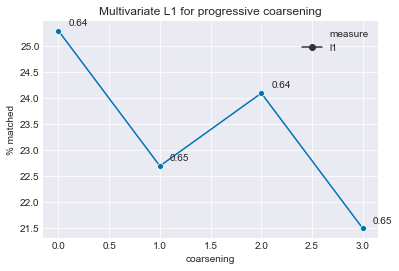

In [21]:
relaxed.plot()

## L1 for depth=0 and one-to-many

In [16]:
# Multivariate imbalance
post = cem.imbalance(coarsening)
print(f'Pre-coarsening L1 imbalance: {round(cem.preimbalance,2)}\nPost-coarsening L1 imbalance: {round(post,2)}')

Pre-coarsening L1 imbalance: 0.89
Post-coarsening L1 imbalance: 0.6


In [17]:
# Univariate imbalance
uni = cem.univariate_imbalance(coarsening)
uni.summary

NameError: name 'params' is not defined

In [ ]:
uni.plot(kde=False)

## Weighted log-linear regression at different coarsenings

Distance is the most important covariate, so we will perform CEM for different level of distance coarsening and regress on the weighted results. We plot the evolution of the regression coefficients for each binning on distance.

In [9]:
coarsening = {
    'dist': {'bins': 4, 'cut': 'cut'}, # relax over
    'year': {'bins': 5, 'cut': 'cut'}, # uniform so qcut=cut
    'seasons': {'bins': [0, 0.25, 0.75, 1], 'cut': 'qcut'}, # quantiles
    'temperature': {'bins': [0, 0.05, 0.5, 0.95, 1], 'cut': 'qcut'}, #quantiles
    'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
    'pressure': {'bins': [-1,1,4,6], 'cut': 'cut'},
    'postseason': {'bins': 2, 'cut': 'cut'},
    'iced': {'bins': 2, 'cut': 'cut'},
    'precipitation': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
    'turf': {'bins': 2, 'cut': 'cut'},
    'away_game': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
}
coarsening.pop(T)
coarsening

{'dist': {'bins': 4, 'cut': 'cut'},
 'year': {'bins': 5, 'cut': 'cut'},
 'seasons': {'bins': [0, 0.25, 0.75, 1], 'cut': 'qcut'},
 'temperature': {'bins': [0, 0.05, 0.5, 0.95, 1], 'cut': 'qcut'},
 'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
 'pressure': {'bins': [-1, 1, 4, 6], 'cut': 'cut'},
 'postseason': {'bins': 2, 'cut': 'cut'},
 'iced': {'bins': 2, 'cut': 'cut'},
 'precipitation': {'bins': 2, 'cut': 'cut'},
 'turf': {'bins': 2, 'cut': 'cut'},
 'away_game': {'bins': 2, 'cut': 'cut'}}

In [10]:
#model
relax_on = [('dist', range(2,4), 'cut')]
formula = 'good ~ ' + ' + '.join(df.drop(['good']+drop, axis=1).columns) + f' + dist*{T}'
regressed, relaxed = cem.regress(coarsening, relax_on, formula=formula, drop=drop, include_relax=True)

0%|          | 0/2 [00:00<?, ?it/s]Regressing with 2 different pd.cut binnings on "dist"

100%|██████████| 2/2 [00:17<00:00,  8.85s/it]


In [11]:
regressed.results

result
var  n_bins                                                   
dist 2       <statsmodels.genmod.generalized_linear_model.G...
     3       <statsmodels.genmod.generalized_linear_model.G...

In [12]:
regressed.expand()

,,,coef,std err,z,P>|z|,[0.025,0.975]
covariate,n_bins,var,,,,,,
Intercept,2,dist,-81.3681,18.907,-4.304,0.000,-118.425,-44.312
dist,2,dist,-0.1283,0.007,-18.856,0.000,-0.142,-0.115
year,2,dist,0.0437,0.009,4.641,0.000,0.025,0.062
seasons,2,dist,0.0075,0.011,0.666,0.505,-0.015,0.029
temperature,2,dist,0.0116,0.006,1.806,0.071,-0.001,0.024
altitude,2,dist,-1.2255,0.675,-1.815,0.070,-2.549,0.098
wind,2,dist,0.0027,0.011,0.242,0.809,-0.019,0.025
away_game,2,dist,-0.0388,0.101,-0.386,0.700,-0.236,0.158
postseason,2,dist,-0.3772,0.437,-0.863,0.388,-1.234,0.479


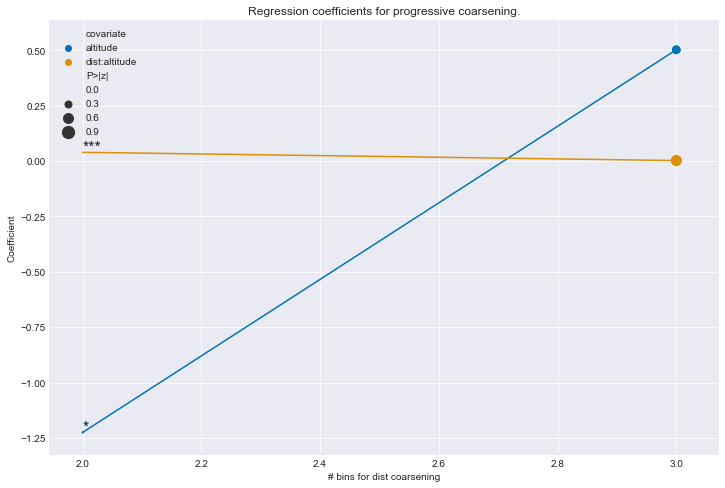

In [13]:
regressed.plot(include=[T, f'dist:{T}'], stars=True)

In [14]:
relaxed.coarsenings

imbalance measure  \
var  n_bins                      
dist 2        0.642842      l1   
     3        0.623432      l1   

                                                    coarsening   bins  \
var  n_bins                                                             
dist 2       {'dist': {'bins': 2, 'cut': 'cut'}, 'year': {'...  34560   
     3       {'dist': {'bins': 3, 'cut': 'cut'}, 'year': {'...  51840   

             treatment_0  treatment_1  
var  n_bins                            
dist 2              3469          547  
     3              3088          519

(<matplotlib.axes._subplots.AxesSubplot at 0x1758da1c188>,
              imbalance measure  \
 var  n_bins                      
 dist 2        0.642842      l1   
      3        0.623432      l1   
 
                                                     coarsening   bins  \
 var  n_bins                                                             
 dist 2       {'dist': {'bins': 2, 'cut': 'cut'}, 'year': {'...  34560   
      3       {'dist': {'bins': 3, 'cut': 'cut'}, 'year': {'...  51840   
 
              treatment_0  treatment_1  # matched  % matched  dist bins  
 var  n_bins                                                             
 dist 2              3469          547       4016       21.4          2  
      3              3088          519       3607       19.2          3  )

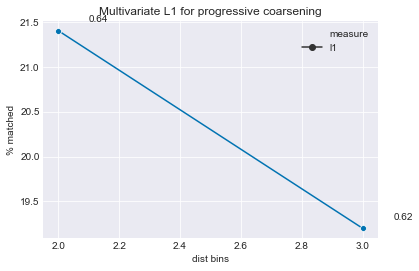

In [15]:
relaxed.plot()

## Weighted difference of means (altitude: for short, medium and long and all-combined groups)

In [ ]:
from matching.cem import LSATT
weights = CEM.match(df.drop('good', axis=1), T, bins)
lsatt = LSATT(df, T, 'good', weights)
print(lsatt)

## k-k log-linear regression at different coarsenings

## k-k difference of means at different coarsenings (altitude: for short, medium and long and all-combined groups)

## k-k Bayesian difference of means at different coarsenings (altitude: for short, medium and long and all-combined groups)

## Model - BOGUS: This kind of modelling doesn't take into account stratum sizes. Will need to weight them if you want to use it.

We work within a Bayesian framework, setting a prior distribution on the true population proportion and update the prior after our observations. The Beta-Binomial conjugacy makes this process relatively pain-free. Our prior mean is the sample population proportion (all kicks).

In [ ]:
# dist_level = (df_matched['dist']>=40) & (df_matched['dist']<50)
dist_level = (df_matched['dist']>=45)
print(len(df_matched.loc[(df_matched[on]==1) & dist_level, :]), on, len(df_matched.loc[(df_matched[on]==0) & dist_level, :]), f'not {on}.')

In [ ]:
from scipy.stats import beta
p_hat = df_matched.loc[dist_level, 'good'].mean()
alpha_ = 10
beta_ = int(round(alpha_*(1-p_hat)/p_hat))
print(f'alpha: {alpha_}, beta: {beta_}')

In [ ]:
from util.bayes import BetaBinomial

control = BetaBinomial(alpha_, beta_, f'not {on}')
treatment = BetaBinomial(alpha_, beta_, on)
control.plot_prior(show=True)
plt.cla()

control.observe(df_matched.loc[(df_matched[on]==0) & dist_level, 'good'])
treatment.observe(df_matched.loc[(df_matched[on]==1) & dist_level, 'good'])

control.plot_posterior(prior=False)
treatment.plot_posterior(show=True, prior=True)

# zoom in
x = np.linspace(0.5,0.9,500)
control.plot_posterior(x, prior=False, show=False)
treatment.plot_posterior(x, prior=False, show=True)

samples = 20000
samples_posterior_c = control.sample(samples)
samples_posterior_t = treatment.sample(samples)

In [ ]:
posterior_diff = samples_posterior_t - samples_posterior_c

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions')
plt.show()
gt = int((samples_posterior_t>samples_posterior_c).mean()*100)
print(f'{gt}% likely that {on} has a greater true population proportion of converted field goals.')

from scipy.stats import bayes_mvs
alpha = 0.5
center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

We are sometimes interested in relative increase. For instance, the difference between 0.6 and 0.7 is relatively larger than the difference between 0.7 and 0.8.
We calculate relative increase of our treatment over control using our posterior distributions.

In [ ]:
posterior_relative = (samples_posterior_t-samples_posterior_c)/samples_posterior_c
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title(f'Posterior distribution of relative lift for {on} kicks over not-{on} kicks.')
print(int((posterior_relative>0.05).mean()*100), r'% likely relative lift is greater than 5%.')

alpha = 0.5
center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')